# Data process

In [2]:
import os
import subprocess
import gzip
import io
import json
import re
from tqdm import tqdm
import pandas as pd
import numpy as np
import nltk.data

In [4]:
# Find sentence-citataion pairs that have more than 10 words in the sentence

def find_pair(textl, bibl):
    pair_dict = {}
    for para in textl:
        cite_list = para['cite_spans']
        text = para['text']
        for cite in cite_list:
            start = int(cite['start'])
            end = int(cite['end'])
            # If cite_spans out of the sentence
            if text[start-2] in ['.', '!', '?']:
                i = start-3
                while i >= 0:
                    if text[i] in ['.', '!', '?']:
                        break
                    i = i - 1
                while i <= start-2:
                    if re.match("[A-Z]", text[i]) == None:
                        i = i + 1
                    else:
                        break
                sentence = text[i:start-1]
                sentence_len = len(sentence.split(' '))
                ref_id = cite['ref_id']
                bib_id = bibl.get(ref_id, 'not exist')
                if bib_id == 'not exist':
                    paper_id = None
                else:
                    paper_id = bibl[ref_id]['link']
                if paper_id != None and sentence_len >= 10:
                    pair_dict[paper_id] = sentence
                    
            # If cite_spans in the sentence
            if end + 1 < len(text):
                if text[end+1] in ['.', '!', '?']:
                    i = start-1
                    while i >= 0:
                        if text[i] in ['.', '!', '?']:
                            break
                        i = i - 1
                    while i <= start-2:
                        if re.match("[A-Z]", text[i]) == None:
                            i = i + 1
                        else:
                            break
                    sentence = text[i:end+2]
                    sentence_len = len(sentence.split(' '))
                    ref_id = cite['ref_id']
                    bib_id = bibl.get(ref_id, 'not exist')
                    if bib_id == 'not exist':
                        paper_id = None
                    else:
                        paper_id = bibl[ref_id]['link']
                    if paper_id != None and sentence_len >= 10:
                        pair_dict[paper_id] = sentence
    
    return pair_dict

def find_cite(textl, bibl):
    citation = set()
    for para in textl:
        cite_list = para['cite_spans']
        text = para['text']
        for cite in cite_list:
            ref_id = cite['ref_id']
            bib_id = bibl.get(ref_id, 'not exist')
            if bib_id == 'not exist':
                paper_id = None
            else:
                paper_id = bibl[ref_id]['link']
            if paper_id != None:
                citation.add(paper_id)
            
    citation = list(citation)
    return citation

In [9]:
def data_preprocessor(df_meta, df_pdf):
    
    # Collect title and abstract

    df = pd.DataFrame(df_meta.loc[:, 'title'])
    for i in df.index:
        if i in df_pdf.index:
            if df_pdf.at[i, 'abstract'] != [] and df_pdf.at[i, 'abstract'] != '':
                df.at[i, 'abstract'] = df_pdf.at[i, 'abstract'][0]['text']

    df.replace('', np.nan, inplace=True)
    df = df.dropna()
            
    # Collect related work text and conclusions text
    # Collect main text by connecting abstract, introduction and conclusion

    for i in df.index:
        if i in df_pdf.index:
            
            relatedwork_text = ''
            main_text = ''
            
            if df_pdf.at[i, 'abstract'] != [] and df_pdf.at[i, 'abstract'] != '':
                main_text += df_pdf.at[i, 'abstract'][0]['text']
                
            for sec in df_pdf.loc[i,'body_text']:
                if sec['section'].lower() == 'related work' and sec['text'] != '' and sec['text'] != []:
                    relatedwork_text += sec['text']
                elif sec['section'].lower()  == 'introduction' and sec['text'] != '' and sec['text'] != []:
                    main_text += sec['text']
                elif sec['section'].lower()  == 'conclusion' and sec['text'] != '' and sec['text'] != []:
                    main_text += sec['text']
                    
            df.at[i, 'relatedwork_text'] = relatedwork_text
            df.at[i, 'main_text'] = main_text

    # Remove papers that don't have related work sections 
    df['relatedwork_text'].replace('', np.nan, inplace=True)
    df = df.dropna()
            
    # collect citations in related work section
    df['rw_citations'] = ''
    
    for i in df.index:
        if i in df_pdf.index:
            for sec in df_pdf.loc[i, 'body_text']:
                if sec['section'].lower() == 'related work' and sec['text'] != '' and sec['text'] != []:
                    full_textl = [sec]

            bibl = df_pdf.at[i, 'bib_entries']
            citations = find_cite(full_textl, bibl)
            df.at[i, 'rw_citations'] = citations
            
    # collect citations
    df['full_citations'] = ''
    
    for i in df.index:
        if i in df_pdf.index:
            full_textl = df_pdf.at[i, 'body_text']
            bibl = df_pdf.at[i, 'bib_entries']
            citations = find_cite(full_textl, bibl)
            df.at[i, 'full_citations'] = citations

    # Remove papers that don't have citations in related work sections and body texts        
    data_processed = df.loc[(df.rw_citations != '') & (df.full_citations != '')]
    
    pd.options.mode.chained_assignment = None
            
    # Remove papars that have fewer than four citation in the related work section
    for i in data_processed.index:
        data_processed.at[i, 'length'] = int(len(data_processed.loc[i, 'rw_citations']))
    data_processed = data_processed.loc[data_processed.length > 4].iloc[:, :-1]        
            
    return data_processed

In [21]:
meta_dir = '../dataset/SS/metadata/CS/'
pdf_dir = '../dataset/SS/pdf_parses/CS/'

meta_files = os.listdir(meta_dir)
pdf_files = os.listdir(pdf_dir)


for i in np.arange(len(meta_files)):
    
    meta_list = []
    
    with open(os.path.join(meta_dir, meta_files[i]), 'r') as json_file:
        json_list = list(json_file)
        
        for json_str in json_list:
            result = json.loads(json_str)
            meta_list.append(result)
        
    pdf_list = []

    with open(os.path.join(pdf_dir, pdf_files[i]), 'r') as json_file:
        json_list = list(json_file)
        
        for json_str in json_list:
            result = json.loads(json_str)
            pdf_list.append(result) 
            
    df_meta = pd.DataFrame(meta_list)
    df_meta = df_meta.set_index('paper_id')
    
    df_pdf = pd.DataFrame(pdf_list)
    df_pdf = df_pdf.set_index('paper_id')
    
    data_processed = data_preprocessor(df_meta, df_pdf)
    
    if i == 0:
        df = data_processed
        print(pdf_files[i], 'filtered')
    else:
        df = df.append(data_processed)
        print(pdf_files[i], 'filtered')

pdf_parses_0.jsonl filtered
pdf_parses_1.jsonl filtered
pdf_parses_10.jsonl filtered
pdf_parses_11.jsonl filtered
pdf_parses_12.jsonl filtered
pdf_parses_13.jsonl filtered
pdf_parses_14.jsonl filtered
pdf_parses_15.jsonl filtered
pdf_parses_16.jsonl filtered
pdf_parses_17.jsonl filtered
pdf_parses_18.jsonl filtered
pdf_parses_19.jsonl filtered
pdf_parses_2.jsonl filtered
pdf_parses_20.jsonl filtered
pdf_parses_21.jsonl filtered
pdf_parses_22.jsonl filtered
pdf_parses_23.jsonl filtered
pdf_parses_24.jsonl filtered
pdf_parses_25.jsonl filtered
pdf_parses_26.jsonl filtered
pdf_parses_27.jsonl filtered
pdf_parses_28.jsonl filtered
pdf_parses_29.jsonl filtered
pdf_parses_3.jsonl filtered
pdf_parses_30.jsonl filtered
pdf_parses_31.jsonl filtered
pdf_parses_32.jsonl filtered
pdf_parses_33.jsonl filtered
pdf_parses_34.jsonl filtered
pdf_parses_35.jsonl filtered
pdf_parses_36.jsonl filtered
pdf_parses_37.jsonl filtered
pdf_parses_38.jsonl filtered
pdf_parses_39.jsonl filtered
pdf_parses_4.jsonl

In [24]:
df.to_pickle('../dataset/SS/clean/filtered_data.pkl')

## Sentence Split

In [ ]:
pd.options.mode.chained_assignment = None

col_names = ['abstract', 'full_text', 'related_work_text']

for col in col_names:
    new_col = col + "_split"
    df.at[:, new_col] = df[col]

for i in data_processed.index:
    for col in col_names:
        new_col = col + "_split"
        df.at[i, new_col] = nltk.tokenize.sent_tokenize(df.loc[i, col])

## Data Visualization

In [3]:
df = pd.read_pickle('../dataset/SS/clean/filtered_data.pkl')

In [4]:
len(df)

27417

In [5]:
df.head()

,title,abstract,relatedwork_text,main_text,rw_citations,full_citations
paper_id,,,,,,
859921,Summarizing Reviews with Variable-length Synta...,Abstract. We present a novel summarization fra...,We first look at how text excerpts are extract...,Abstract. We present a novel summarization fra...,"[5965756, 1599046, 3177797, 444032, 6884774]","[1599046, 11055565, 16393334, 2481864, 5965756..."
129124,Can Document Selection Help Semi-supervised Le...,Annotating training data for event extraction ...,Self-training has been applied to several natu...,Annotating training data for event extraction ...,"[1398439, 7419156, 11187670, 8336242, 15894892...","[1398439, 7419156, 7579604, 11187670, 8336242,..."
1345235,Optimizing Sparse Matrix–Vector Product Comput...,Large-scale scientific applications frequently...,A variety of different data and computation re...,Large-scale scientific applications frequently...,"[1794629, 9580801, 120335238, 15090599, 208582...","[1794629, 9580801, 120335238, 15090599, 208582..."
2624639,Enhanced Chosen-Ciphertext Security and Applic...,We introduce and study a new notion of enhance...,ECCA is similar in spirit to coin-revealing se...,We introduce and study a new notion of enhance...,"[41204165, 19655, 235427, 226828, 3148885]","[443317, 41204165, 7113862, 10098664, 226828, ..."
146120525,ARSM: Augment-REINFORCE-Swap-Merge Estimator f...,To address the challenge of backpropagating th...,"For optimizing (1) for categorical z, the diff...",To address the challenge of backpropagating th...,"[3535369, 5859948, 1758804, 10756562, 19115634...","[121929631, 4043645, 5859948, 7195970, 1075656..."


In [6]:
from matplotlib import pyplot as plt

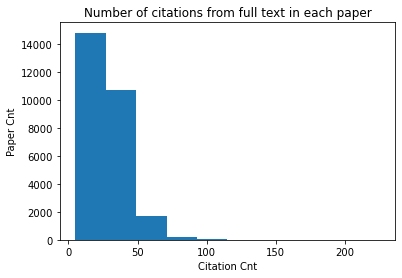

In [8]:
# number of citations in each paper from full text

body_counts = []
for paper_id in df.index:
    current_count = len(df.loc[paper_id, 'full_citations'])
    body_counts.append(current_count)

plt.hist(body_counts)
plt.title('Number of citations from full text in each paper')
plt.xlabel('Citation Cnt')
plt.ylabel('Paper Cnt')
plt.show()

In [9]:
print("The minimum of citations in body text is", min(body_counts))
print("The maximum of citations in body text is", max(body_counts))
print('The average of citations in body text is', round(np.mean(body_counts)))

The minimum of citations in body text is 5
The maximum of citations in body text is 225
The average of citations in body text is 27


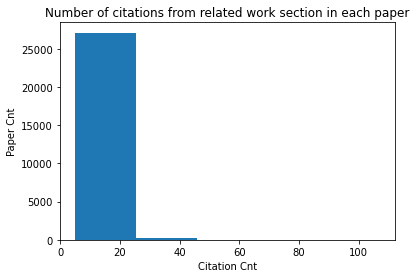

In [10]:
# number of citations in each paper from related work sections

related_work_counts = []
for paper_id in df.index:
    current_count = len(df.loc[paper_id, 'rw_citations'])
    related_work_counts.append(current_count)

plt.hist(related_work_counts, 5)
plt.title('Number of citations from related work section in each paper')
plt.xlabel('Citation Cnt')
plt.ylabel('Paper Cnt')
plt.show()

In [11]:
print("The minimum of citations in related work section is", min(related_work_counts))
print("The maximum of citations in related work section is", max(related_work_counts))
print('The average of citations in related work is', round(np.mean(related_work_counts)))

The minimum of citations in related work section is 5
The maximum of citations in related work section is 107
The average of citations in related work is 8


In [15]:
full_cite = [x for subset in df.full_citations for x in subset]
total_cite = set(full_cite)

cite_count = sum([True for x in list(total_cite) if x in df.index])
        
cite_perc = (cite_count/df.shape[0])*100

print ('{0:.2f}% of cited papers appear in filtered dataset'.format(cite_perc))

29.74% of cited papers appear in filtered dataset


In [16]:
print('The number of papers in filtered dataset is', len(df))
print('The number of cited papers in filtered dataset is', cite_count)

The number of papers in filtered dataset is 27417
The number of cited papers in filtered dataset is 8154
